In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
df = pd.read_csv('../data/clustering_editors.csv')

# we are interested in the users behaviour for 2 months before and 2 months after getting the
# badge
df = df[(df.days > -63) & (df.days <= 61)]
df.head()

,UserId,days,edit_count
0,9143011,-3,5
1,9143011,-4,4
2,9143011,-1,36
3,9143011,1,7
4,9143011,-2,10


In [3]:
# how many unique users are there in this sample
len(df.UserId.unique())

427

In [4]:
# get counts of edits per day
edits_per_day = df.pivot(index='UserId', columns='days', values='edit_count').fillna(0)
edits_per_day.head()

days,-62,-61,-60,-59,-58,-57,-56,-55,-54,-53,...,52,53,54,55,56,57,58,59,60,61
UserId,,,,,,,,,,,,,,,,,,,,,
6408573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6412824,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6412888,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
6413377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6414102,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,5.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0


In [5]:
# get the consistency per period
def get_number_of_days_worked(period, df):
    
    periods = np.arange(df.columns.min(), df.columns.max(), period)
    
    result = pd.DataFrame()
    
    for start, end in zip(periods[:-1], periods[1:]):
        # count the non-zero days in this period
        result = pd.concat([result, df.loc[:,start:end].astype(bool).sum(axis=1)], axis=1)
        
    return result

# get the intensity per period (mean # edits per day)
def get_average_edits_per_day_in_period(period, df):
    
    periods = np.arange(df.columns.min(), df.columns.max(), period)
    
    result = pd.DataFrame()
    
    for start, end in zip(periods[:-1], periods[1:]):
        # count the non-zero days in this period
        result = pd.concat([result, df.loc[:,start:end].mean(axis=1)], axis=1)
        
    return result

In [8]:
days_worked = get_number_of_days_worked(7, edits_per_day).values
average_edits = get_average_edits_per_day_in_period(7, edits_per_day).values
X = np.concatenate([days_worked, average_edits], axis=1)

# sanity check that the dimensions have come out correctly
print('Design matrix has shape:', X.shape)

# take a peak at the new feature matrix
X

Design matrix has shape: (427, 34)


array([[0.   , 2.   , 4.   , ..., 0.   , 0.   , 0.   ],
       [2.   , 2.   , 3.   , ..., 0.125, 0.125, 0.   ],
       [2.   , 0.   , 0.   , ..., 1.125, 0.875, 2.125],
       ...,
       [1.   , 3.   , 4.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.375, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [14]:
# standardize the metrics along the columns
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# check the means along columns are 0
X_s.mean(axis=0)

array([ 2.08004314e-17,  4.16008627e-18, -6.24012941e-18, -5.82412078e-17,
       -8.32017255e-17,  9.15218980e-17,  2.91206039e-17, -1.66403451e-17,
        3.53607333e-17,  1.33122761e-16,  6.44813373e-17,  8.32017255e-18,
       -3.74407765e-17, -1.66403451e-17, -9.56819843e-17,  7.07214667e-17,
       -8.32017255e-17,  4.99210353e-17,  4.99210353e-17,  3.12006471e-18,
        2.70405608e-17, -6.03212510e-17,  1.04002157e-17,  1.66403451e-17,
        2.02804206e-17, -5.82412078e-17,  3.95208196e-17, -1.24802588e-17,
       -8.32017255e-18, -1.66403451e-17,  2.08004314e-17, -4.16008627e-17,
        2.49605176e-17, -8.32017255e-18])

In [15]:
pca = PCA()
pca.fit(X_s)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
pca.explained_variance_ratio_

array([0.35415555, 0.18139865, 0.07697721, 0.05188982, 0.04621586,
       0.04101547, 0.03101662, 0.02306286, 0.02042002, 0.01891517,
       0.0166152 , 0.01466367, 0.01301799, 0.01165597, 0.01104588,
       0.00928639, 0.00848901, 0.00756688, 0.00692721, 0.00669891,
       0.00659029, 0.00567018, 0.00490118, 0.00459317, 0.00451312,
       0.00383684, 0.0036707 , 0.00306124, 0.00277649, 0.0026021 ,
       0.00206967, 0.00181847, 0.00146784, 0.00139437])

In [17]:
print(f'First 5 components explain {100*np.sum(pca.explained_variance_ratio_[:5])}% of the variance')

First 5 components explain 71.06370959054563% of the variance


In [18]:
pca.components_[0]

array([0.09372323, 0.11851073, 0.13878778, 0.14922745, 0.15085158,
       0.16342185, 0.16994418, 0.14899516, 0.12623869, 0.17031677,
       0.19736378, 0.20541915, 0.2217144 , 0.22388088, 0.21693945,
       0.20906656, 0.19765963, 0.08709491, 0.11616763, 0.13295777,
       0.14799152, 0.1529151 , 0.16462881, 0.17746427, 0.16486423,
       0.10328904, 0.16152706, 0.1834189 , 0.17576235, 0.20231487,
       0.21858552, 0.21146806, 0.20348157, 0.18421295])

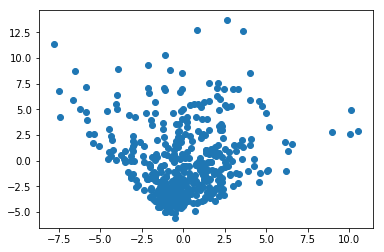

In [19]:
reduced = pca.transform(X_s)
plt.scatter(reduced[:,1], reduced[:,0])

In [20]:
# could use PCA to define the groups... I don't see how we are better off than before though
group1 = np.where((reduced[:,0] <= 0) & (reduced[:,1] <= 0))[0]
group2 = np.where((reduced[:,0] > 0) & (reduced[:,1] <= 0))[0]
group3 = np.where((reduced[:,0] > 0) & (reduced[:,1] > 0))[0]
group4 = np.where((reduced[:,0] <= 0) & (reduced[:,1] > 0))[0]

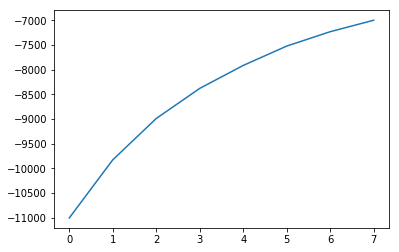

In [23]:
# Better yet. Let's use K-means
scores = []
for i in range(2, 10):
    score = KMeans(n_clusters=i, random_state=11).fit(X_s).score(X_s)
    scores.append(score)
plt.plot(scores)

Note in the above plot that there is no clear 'elbow' where K-menas has found a 'good' clustering. This isn't ideal.

In [24]:
# let's choose 4 groups regardless
kmeans = KMeans(n_clusters=4, random_state=11).fit(X_s)
groups = kmeans.predict(X_s)

group1 = np.where(groups == 0)[0]
group2 = np.where(groups == 1)[0]
group3 = np.where(groups == 2)[0]
group4 = np.where(groups == 3)[0]

Text(0.5, 1.0, 'Entire Population')

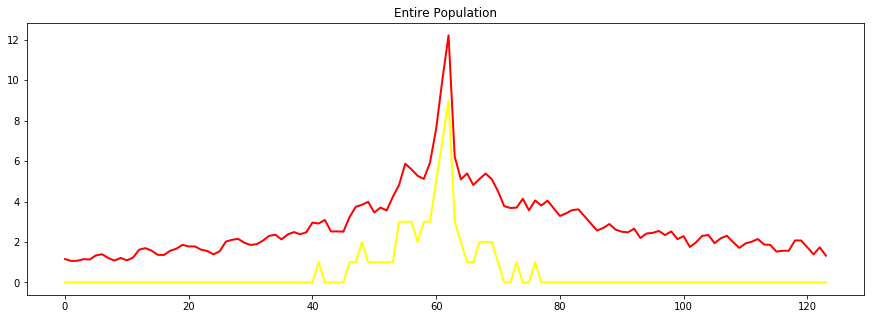

In [25]:
plt.figure(figsize=(15,5))
plt.plot(np.median(edits_per_day.values, axis=0), c='yellow', lw=2)
plt.plot(np.mean(edits_per_day.values, axis=0), c='red', lw=2)
plt.title('Entire Population')

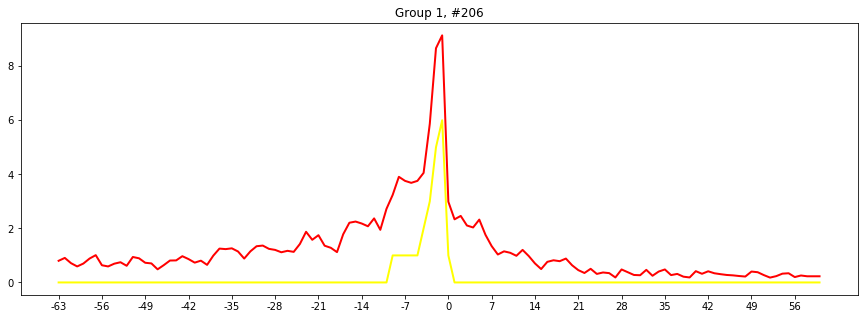

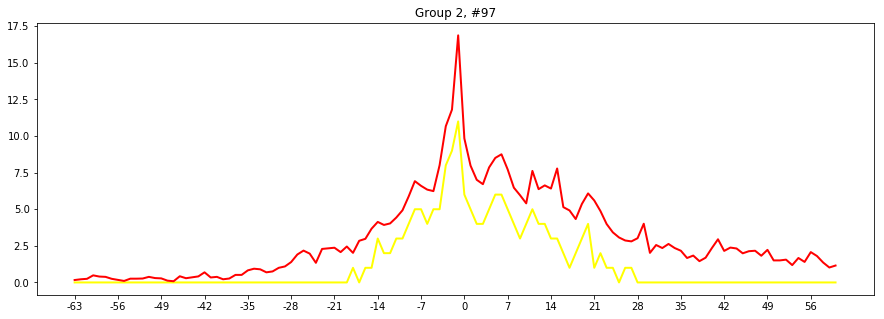

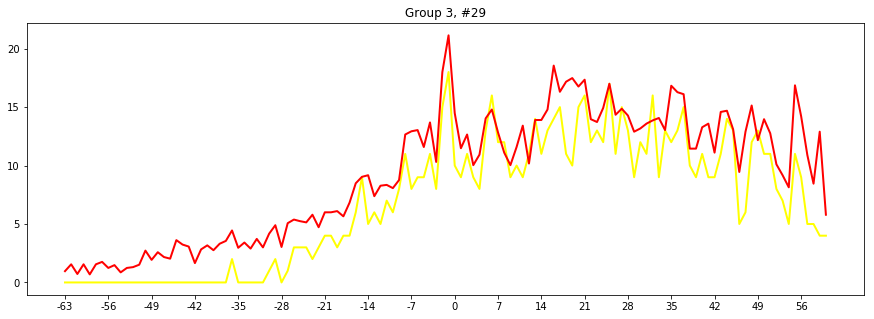

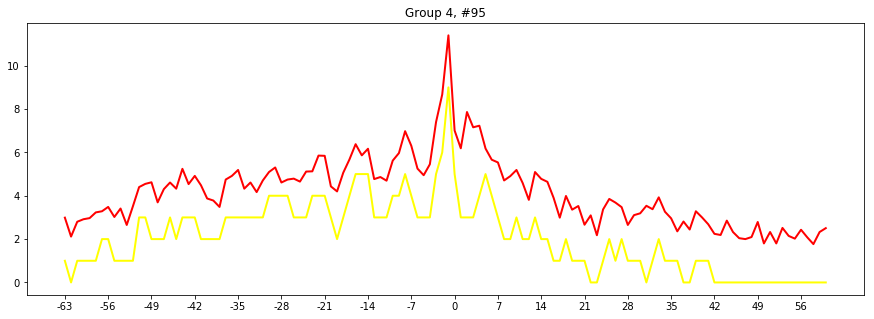

In [26]:
plt.figure(figsize=(15,5))
# plt.plot(edits_per_day.values[group1].T, alpha=.1, c='b')
plt.plot(np.median(edits_per_day.values[group1], axis=0), c='yellow', lw=2)
plt.plot(np.mean(edits_per_day.values[group1], axis=0), c='red', lw=2)
plt.title(f'Group 1, #{len(group1)}')
plt.xticks(np.arange(0,63+63,7), np.arange(-63,63,7))
plt.show()

plt.figure(figsize=(15,5))
# plt.plot(edits_per_day.values[group2].T, alpha=.1, c='b')
plt.plot(np.median(edits_per_day.values[group2], axis=0), c='yellow', lw=2)
plt.plot(np.mean(edits_per_day.values[group2], axis=0), c='red', lw=2)
plt.title(f'Group 2, #{len(group2)}')
plt.xticks(np.arange(0,63+63,7), np.arange(-63,63,7))
plt.show()

plt.figure(figsize=(15,5))
# plt.plot(edits_per_day.values[group3].T, alpha=.1, c='b')
plt.plot(np.median(edits_per_day.values[group3], axis=0), c='yellow', lw=2)
plt.plot(np.mean(edits_per_day.values[group3], axis=0), c='red', lw=2)
plt.title(f'Group 3, #{len(group3)}')
plt.xticks(np.arange(0,63+63,7), np.arange(-63,63,7))
plt.show()

plt.figure(figsize=(15,5))
# plt.plot(edits_per_day.values[group4].T, alpha=.1, c='b')
plt.plot(np.median(edits_per_day.values[group4], axis=0), c='yellow', lw=2)
plt.plot(np.mean(edits_per_day.values[group4], axis=0), c='red', lw=2)
plt.title(f'Group 4, #{len(group4)}')
plt.xticks(np.arange(0,63+63,7), np.arange(-63,63,7))
plt.show()

In [27]:
len(group1), len(group2), len(group3), len(group4)

(206, 97, 29, 95)

In [30]:
print('Group 1 Ids')
for i in edits_per_day.iloc[group1].index:
    print(i, end=',')
print('\n\nGroup 2 Ids')    
for i in edits_per_day.iloc[group2].index:
    print(i, end=',')
print('\n\nGroup 3 Ids')
for i in edits_per_day.iloc[group3].index:
    print(i, end=',')
print('\n\nGroup 4 Ids')
for i in edits_per_day.iloc[group4].index:
    print(i, end=',')

Group 1 Ids
6408573,6412824,6412888,6415268,6426617,6446385,6448351,6468241,6472077,6472853,6478047,6479530,6489036,6489306,6493868,6499716,6509507,6519111,6525260,6530111,6532640,6556960,6557569,6559962,6560478,6563293,6602495,6614295,6617975,6620474,6625726,6629154,6630837,6633975,6637668,6643185,6644368,6654077,6654773,6656269,6656894,6657015,6662421,6677650,6677986,6680583,6680915,6700627,6709604,6710751,6711752,6714194,6719047,6730571,6737234,6742808,6755093,6756033,6756805,6760571,6766146,6768585,6768769,6773022,6782707,6788803,6789498,6794568,6797783,6799340,6803066,6808674,6811846,6813506,6815131,6834114,6857662,6880611,6882276,6886968,6894075,6898523,6908525,6926168,6941627,6944107,6999200,7008044,7018546,7023245,7049894,7071093,7074938,7076153,7084898,7088290,7107027,7108457,7111561,7132550,7148638,7155133,7158505,7169688,7179042,7186095,7200715,7208263,7245145,7250862,7255359,7256199,7281091,7291240,7306168,7334327,7343596,7347631,7359094,7393973,7403180,7405477,7408143,7424

Because each element in the user vector refers to an intensity or consistency score over time, we can interpret these vectors as the 'typical' interaction pattern for the archetypal user of that group.

Text(0.5, 1.0, 'Consistency')

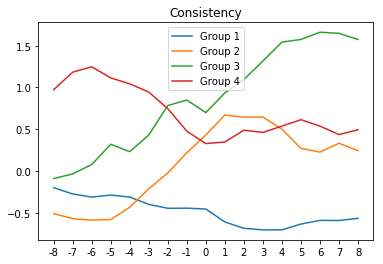

In [33]:
end = len(kmeans.cluster_centers_[0])//2
end

kmeans.cluster_centers_

for i in range(4):
    plt.plot(kmeans.cluster_centers_[i,:end], label=f'Group {i+1}')
plt.xticks(np.arange(0,end), np.arange(-(end-1)//2, (end+1)//2))
plt.legend(loc='best')
plt.title('Consistency')

Text(0.5, 1.0, 'Intensity')

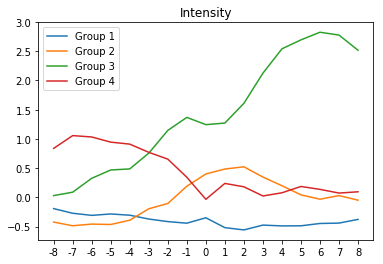

In [34]:
kmeans.cluster_centers_

for i in range(4):
    plt.plot(kmeans.cluster_centers_[i,end:], label=f'Group {i+1}')
plt.xticks(np.arange(0,end), np.arange(-(end-1)//2, (end+1)//2))
plt.legend(loc='best')
plt.title('Intensity')

In [35]:
# Use https://data.stackexchange.com/stackoverflow/query/new to find which users got the Copy Editor badge
# group 1 - 5/206
# group 2 - 35/97
# group 3 - 24/29
# group 4 - 19/95

In [36]:
# does the total number of edits differ significantly between groups?

group1_edits = df[df.UserId.isin(edits_per_day.iloc[group1].index)].groupby('UserId').agg('sum')[['edit_count']]
group2_edits = df[df.UserId.isin(edits_per_day.iloc[group2].index)].groupby('UserId').agg('sum')[['edit_count']]
group3_edits = df[df.UserId.isin(edits_per_day.iloc[group3].index)].groupby('UserId').agg('sum')[['edit_count']]
group4_edits = df[df.UserId.isin(edits_per_day.iloc[group4].index)].groupby('UserId').agg('sum')[['edit_count']]

group1_edits['group']=1
group2_edits['group']=2
group3_edits['group']=3
group4_edits['group']=4

group_edits = pd.concat([group1_edits, group2_edits, group3_edits, group4_edits])
group_edits.head()

,edit_count,group
UserId,,
6408573,283,1
6412824,52,1
6412888,75,1
6415268,141,1
6426617,189,1


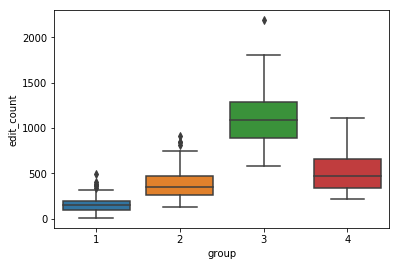

In [37]:
import seaborn as sns
sns.boxplot(x='group', y='edit_count', data=group_edits)